## Importing libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics

import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv

## Setting up the cluster

In [140]:
#cluster.close()

In [23]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-06-28 12:05:10,649 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:10,648 - distributed.scheduler - INFO - State start
2023-06-28 12:05:10,657 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:10,656 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-06-28 12:05:11,589 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:11,587 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:45941'
2023-06-28 12:05:11,597 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:11,597 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:46631'
2023-06-28 12:05:11,599 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:11,599 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:40171'
2023-06-28 12:05:11,612 - distributed.deploy.ssh - INFO - 2023-06-28 12:05:11,611 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:39357'
2023-06-28 12:05:11,621 - distributed.deploy.ssh - INFO - 2023-06-28

In [24]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.2', '6.3.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [25]:
client

<Client: 'tcp://10.67.22.140:8786' processes=6 threads=6, memory=11.63 GiB>

## Data

In [26]:
#defin the value of q to drop
q_drop = 0.2

#import data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')

#Masking on the data
bhbh = bhbh[bhbh['q'] > q_drop] #dropping the value of q under q_drop
#bhbh = bhbh[ bhbh['No_Kick'] == 2] #taking only the binaries without kick

## Discretizing and introducing labels

In [27]:
#add column label
n_bins = 100
# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

## Splitting the data in train and set

In [28]:
bhbh_train, bhbh_test = train_test_split(bhbh, train_size=0.7, shuffle=True)

bhbh_train = bhbh_train.reset_index(drop=True) # just for simplicity sake in the final visualisation
bhbh_test = bhbh_test.reset_index(drop=True)   # and so that we don't mess up later when checking the results

#Repartition for xgboost
bhbh_train = bhbh_train#.repartition(240)

## Sample weigths

In [29]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

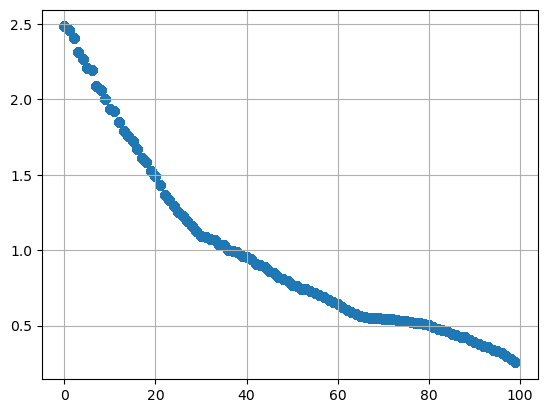

In [10]:
plt.scatter(bhbh_train['label'], bhbh_train['weight'])
plt.grid()
plt.show()

## Rename of useful columns

In [30]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [12]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

## Custom objective function EMD

In [13]:
#EMD loss function
def cdf_emd(x, y):
    """Compute the CDF-EMD loss between two probability distributions."""
    n = x.shape[0]
    A = np.tril(np.ones((n, n)))
    res = A @ (x - y)
    res = (1 / n) * np.dot(res, res)
    return res

#first and second derivatives
def cdf_emd_grad(x, y):
    """Compute the gradient of the CDF-EMD loss."""
    n = x.shape[0]
    A = np.tril(np.ones((n, n)))
    res = (2 / n) * A.T @ A @ (x - y)
    return res

def cdf_emd_hess(x, y):
    """Compute the Hessian of the CDF-EMD loss."""
    n = x.shape[0]
    A = np.tril(np.ones((n, n)))
    res = (2 / n) * A.T @ A
    return res

#Custom objective function (it uses loss function, first and second derivatives)
def CDF_EMD_LOSS(data: np.ndarray, predt: np.ndarray):
    data = data.reshape(predt.shape)
    kRows, kClasses = predt.shape
    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float) 
    
    for r in range(kRows):
        x = predt[r].copy()
        y = data[r].copy()
        grad[r, :] = cdf_emd_grad(x, y)
        hess[r, :] = np.diag(cdf_emd_hess(x, y))

    grad = grad.reshape((kRows * kClasses, 1))
    hess = hess.reshape((kRows * kClasses, 1))
    return grad, hess

In [14]:
#parameters
max_depth = 0
learning_rate = 0.2
grow_policy = 'lossguide'
n_estimators = 5
max_leaves = 400

param = {'objective': CDF_EMD_LOSS,
         'tree_method': 'hist', 
         'n_estimators' : n_estimators, #equivalent to num_boost_round, lets keep it in params
         'grow_policy' : grow_policy, 
         'max_depth' : max_depth,
         'learning_rate' : learning_rate,
         'max_leaves' : max_leaves,
         'num_class': n_bins,
         'n_jobs' : -1,
        }

In [19]:
xgbclassifier = xgb.dask.DaskXGBClassifier(objective = CDF_EMD_LOSS,
                                             n_estimators = n_estimators, #equivalent to num_boost_round, lets keep it in params
                                             grow_policy = grow_policy, 
                                             max_depth = max_depth,
                                             learning_rate = learning_rate,
                                             num_class =  n_bins,
                                             n_jobs = -1,
                                             verbosity = 2)
xgbclassifier.client = client # not used

In [20]:
xgbclass = xgbclassifier.fit(X=features, y=labels, sample_weight=weights)

ValueError: cannot reshape array of size 305272 into shape (305272,100)